## Plot movie timecourses

In [2]:
# RUN THIS CELL
# import packages, check folders
#%reset
from pathlib import Path
import os
import numpy as np
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import time
import pickle

%matplotlib inline

working_dir = '/Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/fMRIScipts/code'
#working_dir = os.getcwd()
print('current directory:\n',working_dir)
path = Path(working_dir)
parent_folder = path.parent
#print('parent folder:', parent_folder)
data_file_loc = os.path.join(parent_folder,'data') # to store data we extract later in this notebook
#data_file_loc = os.getcwd()

current directory:
 /Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/fMRIScipts/code


In [3]:
vidnames = ["COAXING-B", "BILLIARD-A", "DRIFTING-A", "Fishing", 
            "Random mechanical", "Scaring", "SEDUCING-B", "STAR-A", 
            "SURPRISING-B", "TENNIS-A"]

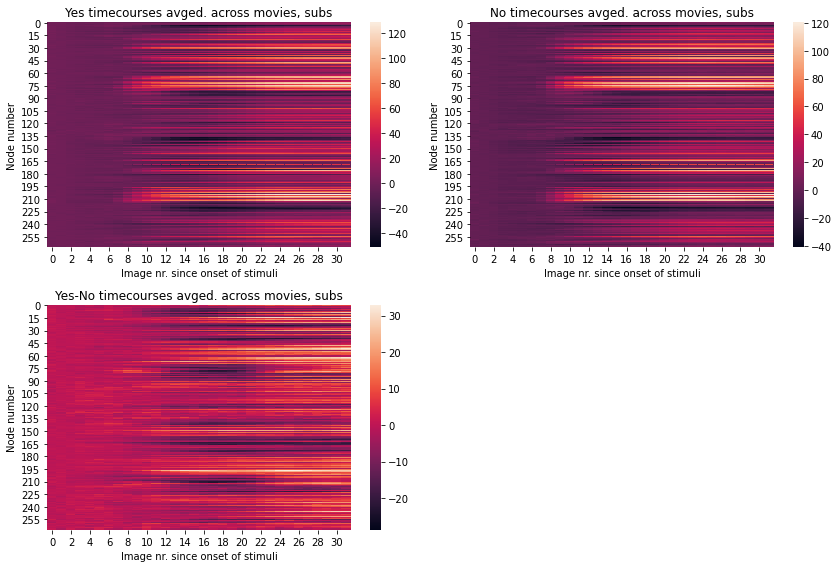

In [4]:
# RUN THIS CELL
def get_mean_timecourses_respbased():
    # returns timeourses and means/medians of yes and no responders separately. 
    # doesn't take any inputs, but data_file_loc (location with responseinfo and movie timecourse) 
    # needs to be previously defined
    # response file has a mat of dims nsub*nmovies
    # each movie timecourse file has the dims: nsub*nnodes*ntimepts(43)
    #responses = np.load(os.path.join(data_file_loc,'responses_slopereg.npy')) # subs*movies
    responses = np.load(os.path.join(data_file_loc,'responses.npy')) # subs*movies
    nmovies = 10
    for movie_ind in range(nmovies):
        fileName = os.path.join(data_file_loc,'timecourses_run_norm',f'timecourse-all-movies.npy')
        movieTC = np.load(fileName) # nsubs * nnodes * ntimepts*nmovies
        movieTC = movieTC[:,:,:,movie_ind]
        
        resp_yes = responses[:,movie_ind] == 1
        resp_no = responses[:,movie_ind] == 0
        resp_unsure = responses[:,movie_ind] == 9
        
        if movie_ind == 0:
            movie_tc_yes = np.empty((movieTC.shape[0],movieTC.shape[1],movieTC.shape[2],nmovies))
            movie_tc_no  = np.empty((movieTC.shape[0],movieTC.shape[1],movieTC.shape[2],nmovies))
            movie_tc_unsure  = np.empty((movieTC.shape[0],movieTC.shape[1],movieTC.shape[2],nmovies))
            movie_tc_yes[:] = np.nan
            movie_tc_no[:] = np.nan
            movie_tc_unsure[:] = np.nan
        
        movie_tc_yes[resp_yes,:,:,movie_ind] = movieTC[resp_yes,:,:] # fills out only yes rows
        movie_tc_no[resp_no,:,:,movie_ind] = movieTC[resp_no,:,:] # fills out only no rows
        movie_tc_unsure[resp_unsure,:,:,movie_ind] = movieTC[resp_unsure,:,:] # fills out only no rows
        # nsubs * nnodes * ntimepts * nmovies
    mean_tc_yes = np.nanmean(movie_tc_yes, axis = (0,3))
    mean_tc_no = np.nanmean(movie_tc_no, axis = (0,3))
    mean_tc_unsure = np.nanmean(movie_tc_unsure, axis = (0,3))
    median_tc_yes = np.nanmedian(movie_tc_yes, axis = (0,3))
    median_tc_no = np.nanmedian(movie_tc_no, axis = (0,3))
    median_tc_unsure = np.nanmedian(movie_tc_unsure, axis = (0,3))
    return movie_tc_yes, movie_tc_no, movie_tc_unsure, mean_tc_yes, mean_tc_no, mean_tc_unsure, median_tc_yes, median_tc_no, median_tc_unsure


movie_tc_yes, movie_tc_no, movie_tc_unsure,mean_tc_yes, mean_tc_no, mean_tc_unsure, median_tc_yes, median_tc_no, median_tc_unsure = \
    get_mean_timecourses_respbased()

plt.figure(1,figsize = (12,8))
plt.subplot(2,2,1)
sns.heatmap(mean_tc_yes)
plt.xlabel('Image nr. since onset of stimuli')
plt.ylabel('Node number')
plt.title('Yes timecourses avged. across movies, subs')

plt.subplot(2,2,2)
sns.heatmap(mean_tc_no)
plt.xlabel('Image nr. since onset of stimuli')
plt.ylabel('Node number')
plt.title('No timecourses avged. across movies, subs')

plt.subplot(2,2,3)
sns.heatmap(mean_tc_yes - mean_tc_no)
plt.xlabel('Image nr. since onset of stimuli')
plt.ylabel('Node number')
plt.title('Yes-No timecourses avged. across movies, subs')
# from last subplot: differences emerge later in all nodes

plt.tight_layout()

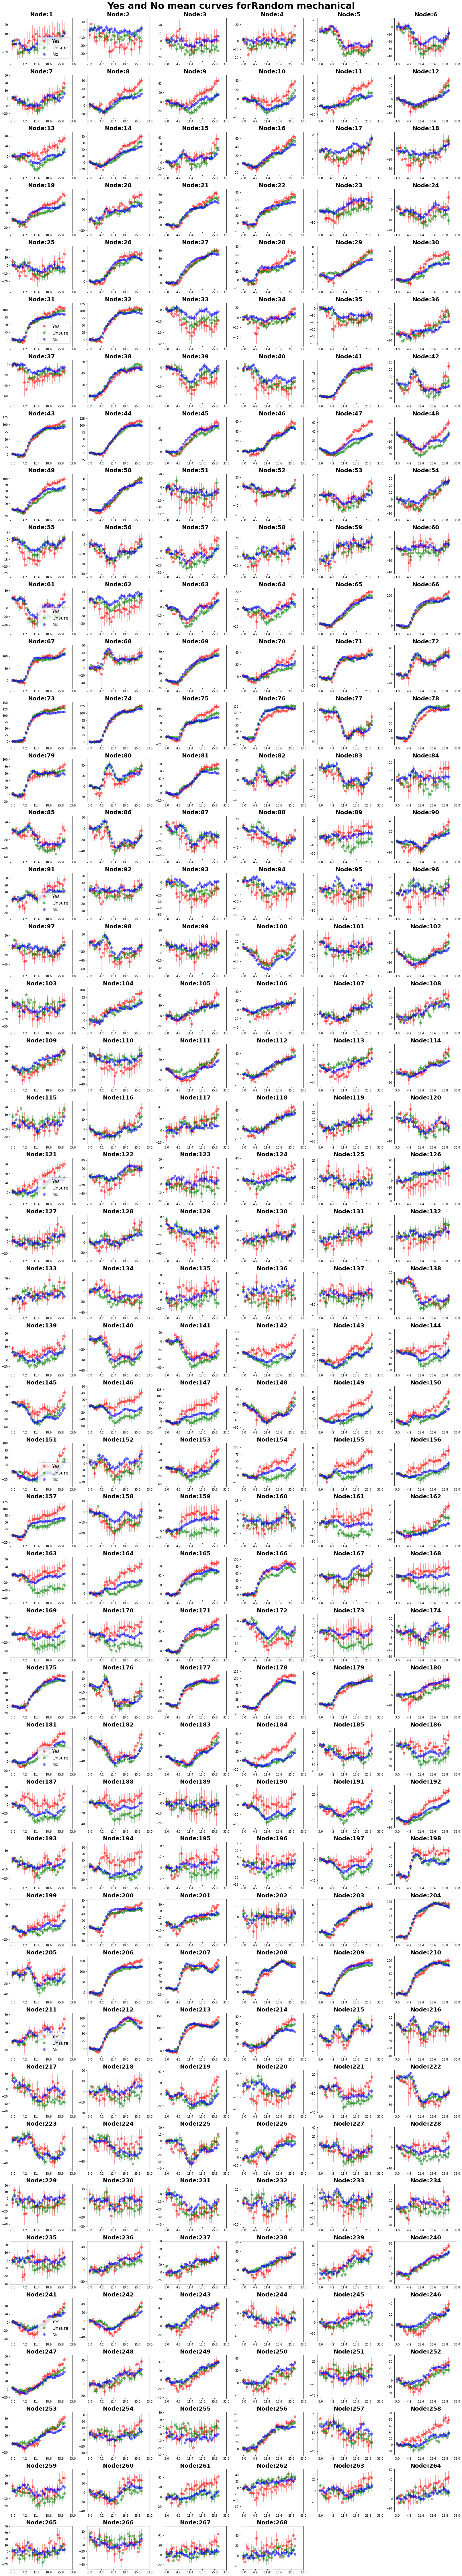

In [6]:
ncols = 6
nrows= int(np.ceil(268/ncols))
#fig, axes = plt.subplots(67,4, figsize=(15,150))
xwidth = 22.5
yheight = 125# .75*nrows*xwidth/ncols
fig, ax = plt.subplots(nrows, ncols, sharex=False, sharey=False, figsize = (xwidth,yheight))
fig.set_figwidth(xwidth)
fig.set_figheight(yheight)
movie_ind = 4
fig.suptitle(f'Yes and No mean curves for{vidnames[movie_ind]}', y=.998,fontsize = 32, fontweight = 'bold')
for n in range(268):
    
    r = int(np.floor(n/ncols))
    c = int(np.floor(n%ncols))
            
    for resp in ['Yes','Unsure','No']:
        if resp =='Yes':
            y = movie_tc_yes[:,n,:,movie_ind]
            col = 'r'
        elif resp =='No':
            y = movie_tc_no[:,n,:,movie_ind]
            col ='b'
        elif resp =='Unsure':
            y = movie_tc_unsure[:,n,:,movie_ind]
            col ='g'
        ax[r,c].errorbar(range(32),np.nanmean(y,axis=0), stats.sem(y,axis=0,nan_policy='omit'),linestyle = 'None', marker = 'o',alpha = .5, markersize = 8, color = col,label = resp)
        ax[r,c].set_xticks(np.linspace(0,36,6))
        ax[r,c].set_xticklabels([str(i-3) for i in np.linspace(0,36,6)])
    ax[r,c].set_title(f'Node:{n+1}', fontweight = 'bold', fontsize = 20)
    if n%30 ==0:
        ax[r,c].legend(loc='lower right', fontsize = 16)
ax[r,c+1].axis('off')
ax[r,c+2].axis('off')
 
plt.tight_layout()